# Benchmarking `gpujpeg` 📊

In [ ]:
%run benchmark_gpujpeg_complete.py

# 📈 Data Visualization & Analysis

Now we will plot the collected data to understand the results. We will focus on:
1.  **Rate-Distortion:** How do quality metrics (like VMAF) change with file size?
2.  **Quality vs. File Size:** How does the `-quality` setting impact file size for different subsampling methods?
3.  **Encoding Performance:** Which Format method is fastest? How does resolution affect encoding time?
4.  **Decoding Performance:** How does resolution affect decoding time?

In [1]:
# --- Main Configuration ---
# Resolutions to test (Name: (Width, Height))
RESOLUTIONS = {
    '1280x720': (1280, 720),
    '1920x1080': (1920, 1080),
    '3840x2160': (3840, 2160),
}

RESOLUTION_TO_FILENAME = {
    '1280x720': 'frame_hd.rgb',
    '1920x1080': 'frame_fullhd.rgb',
    '3840x2160': 'frame_ultrahd.rgb',
}

# Parameters to benchmark
QUALITIES = range(10, 101, 1)
FORMATS = ['planar', 'interleaved']
SUBSAMPLINGS = ['4:4:4', '4:2:2', '4:2:0']
RESTART_INTERVALS = [0, 1, 2, 4, 8, 16, 32, 64, 128]

SUBSAMPLING_TO_PARAM = {
    '4:4:4': '444',
    '4:2:2': '422',
    '4:2:0': '420'
}

In [2]:
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('results_gpujpeg_complete.csv')
df.head()

,Resolution,Quality,Format,Restart Interval,Subsampling,Iterations,Avg Encode Time (s),Encoder Setup Time (s),Encoder Cleanup Time (s),Avg Decode Time (s),Decoder Setup Time (s),Decoder Cleanup Time (s),Compressed Size (KB),PSNR,SSIM,Encode CMD,Decode CMD
0,1280x720,10,planar,0,4:4:4,10,0.003926,0.163467,0.001729,0.002655,0.143895,0.002132,47.283,27.940943,0.796867,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
1,1280x720,10,planar,1,4:4:4,10,0.000769,0.132453,0.001676,0.000560,0.124322,0.001248,146.735,27.940943,0.796867,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
2,1280x720,10,planar,2,4:4:4,10,0.000713,0.128813,0.000917,0.000507,0.129051,0.001309,97.036,27.940943,0.796867,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
3,1280x720,10,planar,4,4:4:4,10,0.000557,0.129385,0.001600,0.000512,0.127723,0.001303,71.885,27.940943,0.796867,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
4,1280x720,10,planar,8,4:4:4,10,0.000531,0.133958,0.001698,0.000524,0.131600,0.001345,59.572,27.940943,0.796867,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...


In [4]:
# Set plot style
sns.set_theme(style="whitegrid")

## Encoding Parameters vs. quality metrics

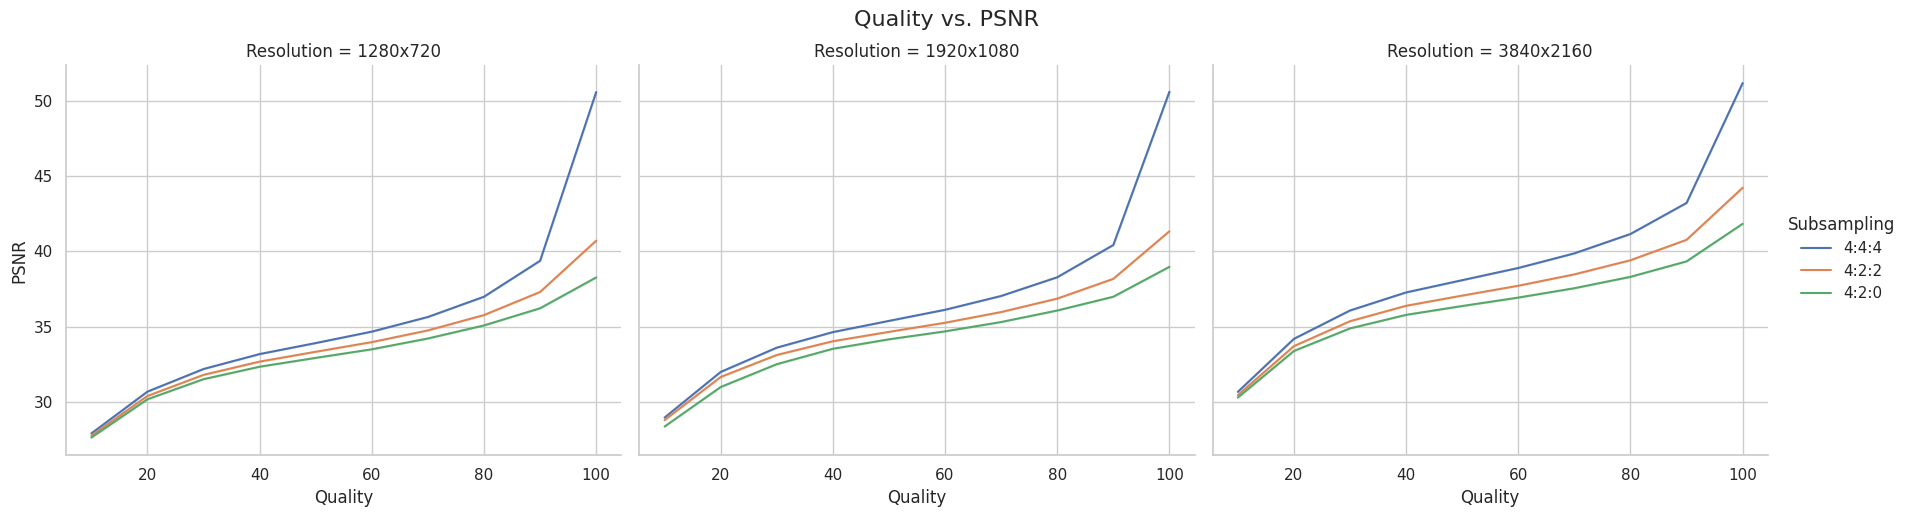

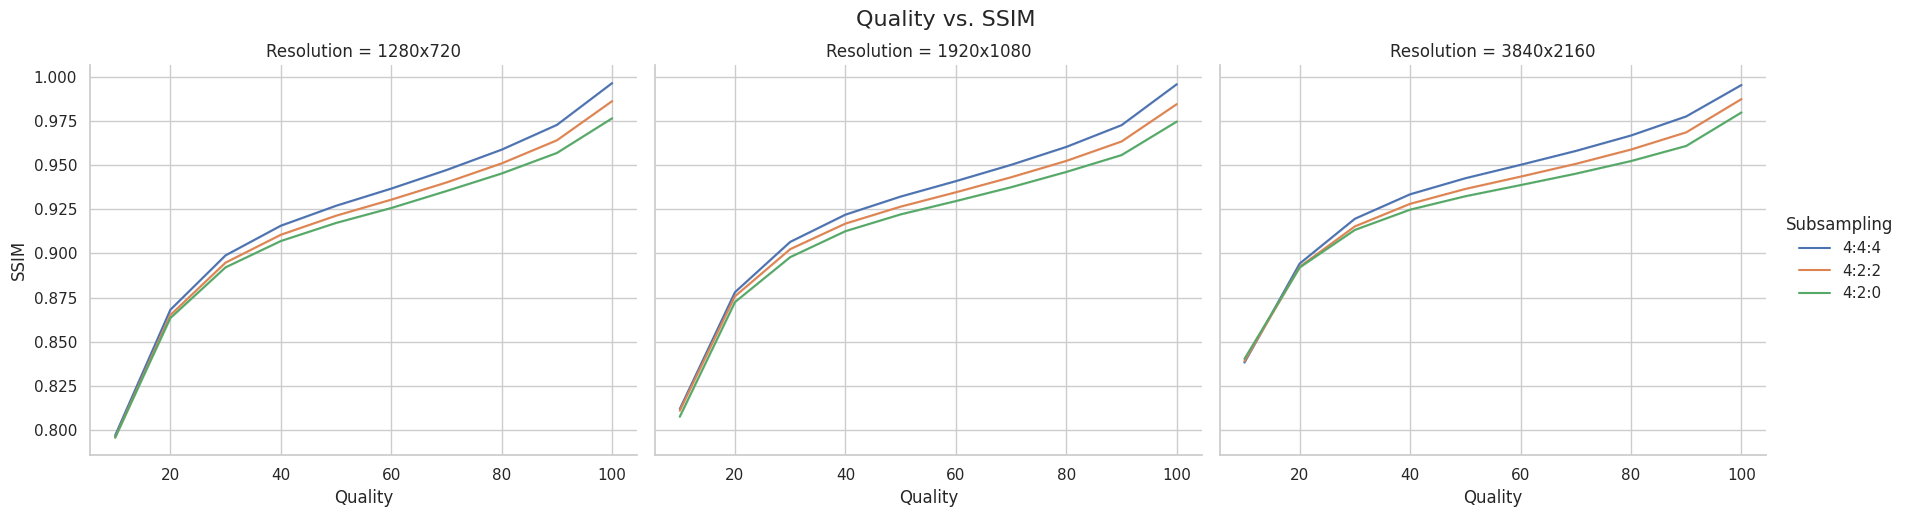

In [5]:
x = 'Quality'
y = 'PSNR'

g = sns.relplot(
    data=df,
    x=x,
    y=y,
    hue='Subsampling',
    col='Resolution',
    kind='line',
    height=5,
    aspect=1.2,
    col_order=RESOLUTIONS.keys(),
    facet_kws={'sharex': False}
)

g.figure.suptitle(f'{x} vs. {y}', y=1.03, fontsize=16)
g.set_axis_labels(x, y)
plt.show()

x = 'Quality'
y = 'SSIM'

g = sns.relplot(
    data=df,
    x=x,
    y=y,
    hue='Subsampling',
    col='Resolution',
    kind='line',
    height=5,
    aspect=1.2,
    col_order=RESOLUTIONS.keys(),
    facet_kws={'sharex': False}
)

g.figure.suptitle(f'{x} vs. {y}', y=1.03, fontsize=16)
g.set_axis_labels(x, y)
plt.show()

## Encoding Parameters vs. File Size


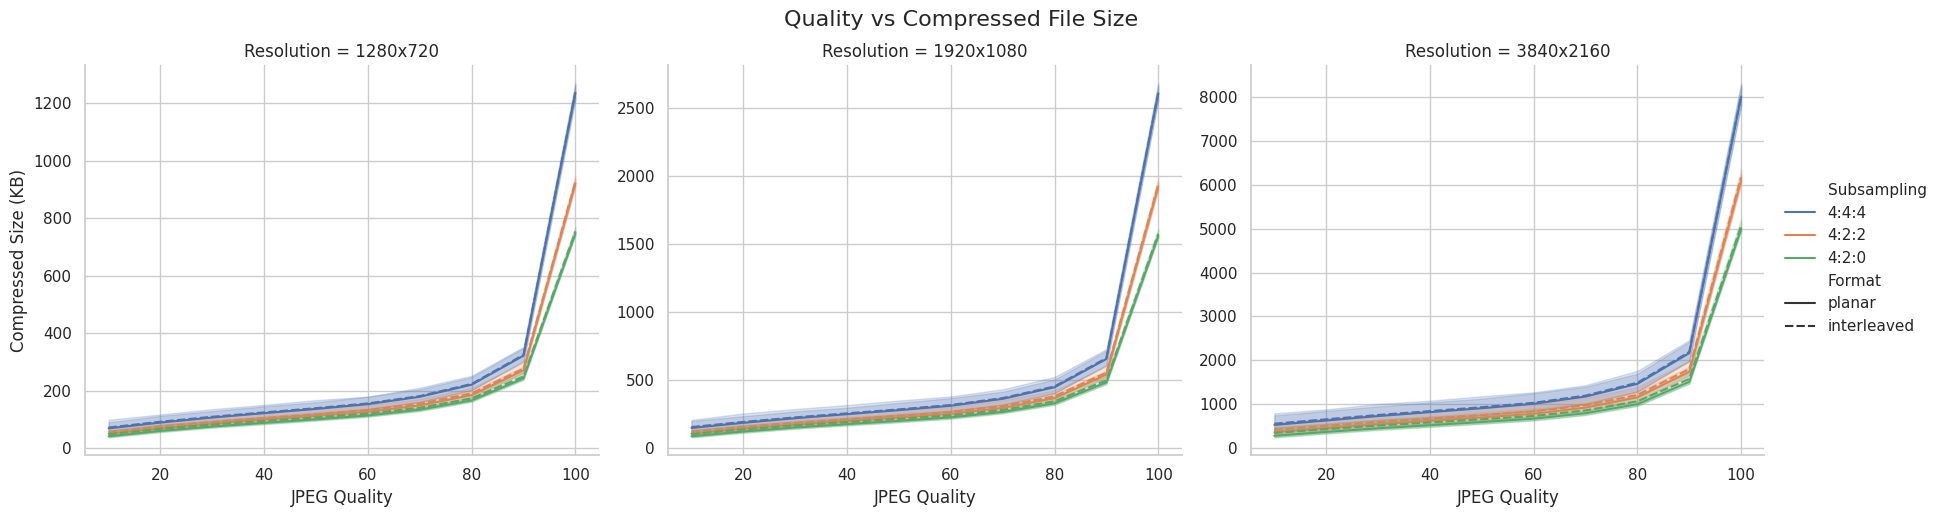

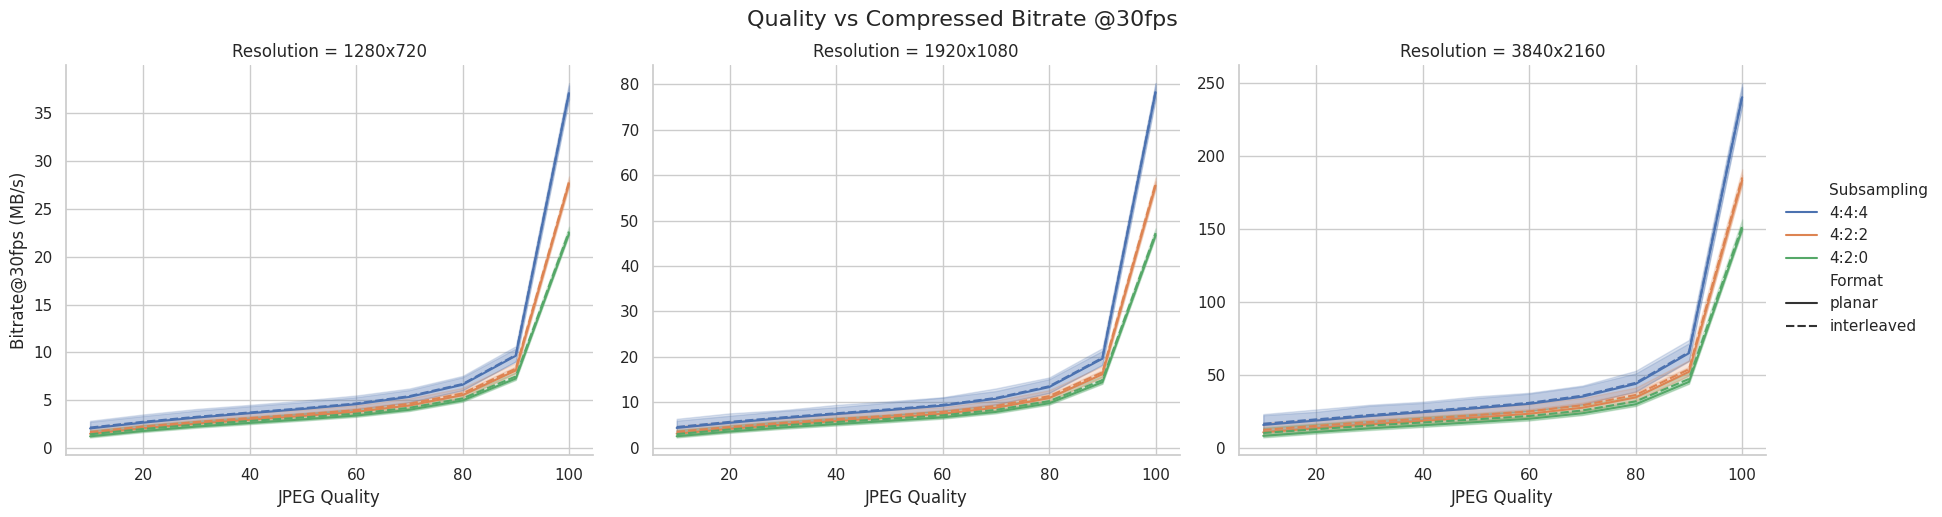

In [6]:
g = sns.relplot(
    data=df,
    x='Quality',
    y='Compressed Size (KB)',
    hue='Subsampling',
    style='Format',
    col='Resolution',
    kind='line',
    height=5,
    aspect=1.2,
    col_order=RESOLUTIONS.keys(),
    facet_kws={'sharey': False}
)
g.figure.suptitle('Quality vs Compressed File Size', y=1.03, fontsize=16)
g.set_axis_labels('JPEG Quality', 'Compressed Size (KB)')
plt.show()

fps = 30
g = sns.relplot(
    data=df,
    x='Quality',
    y=df['Compressed Size (KB)'] * fps / 1000,
    hue='Subsampling',
    style='Format',
    col='Resolution',
    kind='line',
    height=5,
    aspect=1.2,
    col_order=RESOLUTIONS.keys(),
    facet_kws={'sharey': False},
)
g.figure.suptitle(f'Quality vs Compressed Bitrate @{fps}fps', y=1.03, fontsize=16)
g.set_axis_labels('JPEG Quality', f'Bitrate@{fps}fps (MB/s)')
plt.show()

We can observe an explosion in file size from quality 95 onwards, and a sharp increase from quality 90 onwards.

## Encoding Parameters vs. Performance

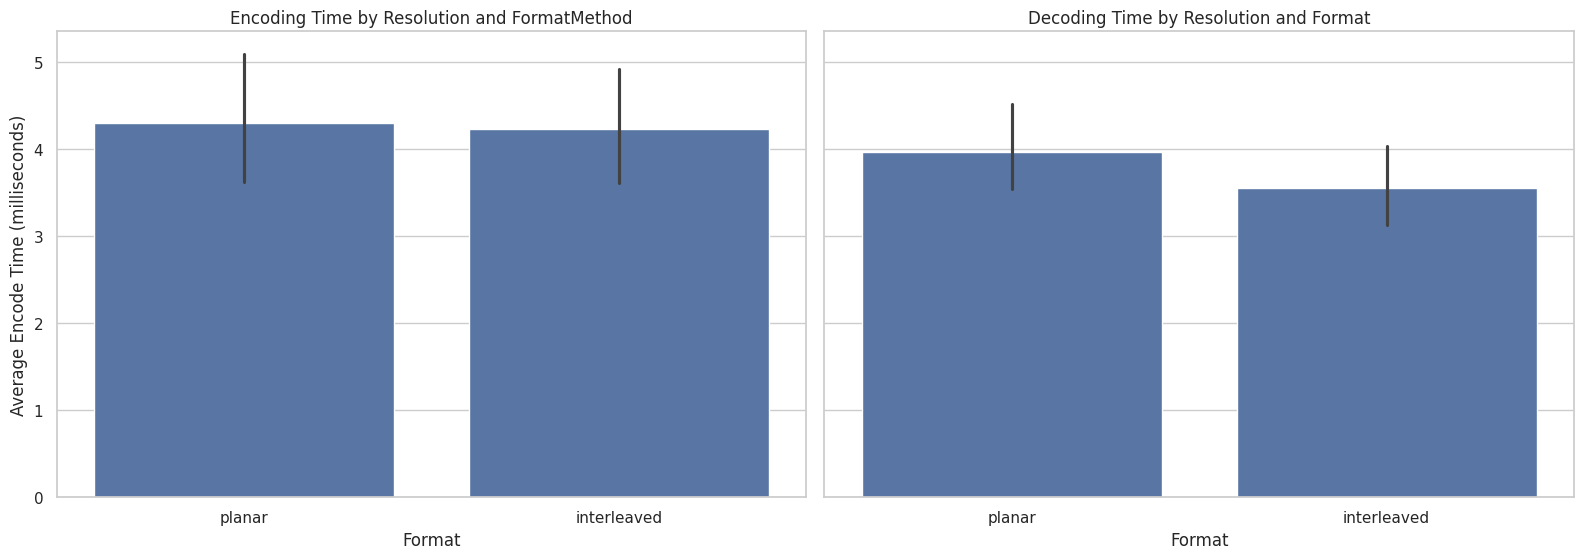

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
# Plot 1: Encoding time by Resolution and Format
#method
sns.barplot(
    data=df,
    x='Format',
    y=df['Avg Encode Time (s)'] * 1000,
    ax=ax[0]
)
ax[0].set_title('Encoding Time by Resolution and FormatMethod')
ax[0].set_ylabel('Average Encode Time (milliseconds)')
ax[0].set_xlabel('Format')
# Plot 2: Decoding time by Resolution and Format
#method
sns.barplot(
    data=df,
    x='Format',
    y=df['Avg Decode Time (s)'] * 1000,
    ax=ax[1]
)
ax[1].set_title('Decoding Time by Resolution and Format')
ax[1].set_ylabel('Average Decode Time (milliseconds)')
ax[1].set_xlabel('Format')
plt.tight_layout(rect=[0.0, 0.0, 1.0, 0.96])
plt.show()

In [8]:
df = df[df['Format'] == 'interleaved']

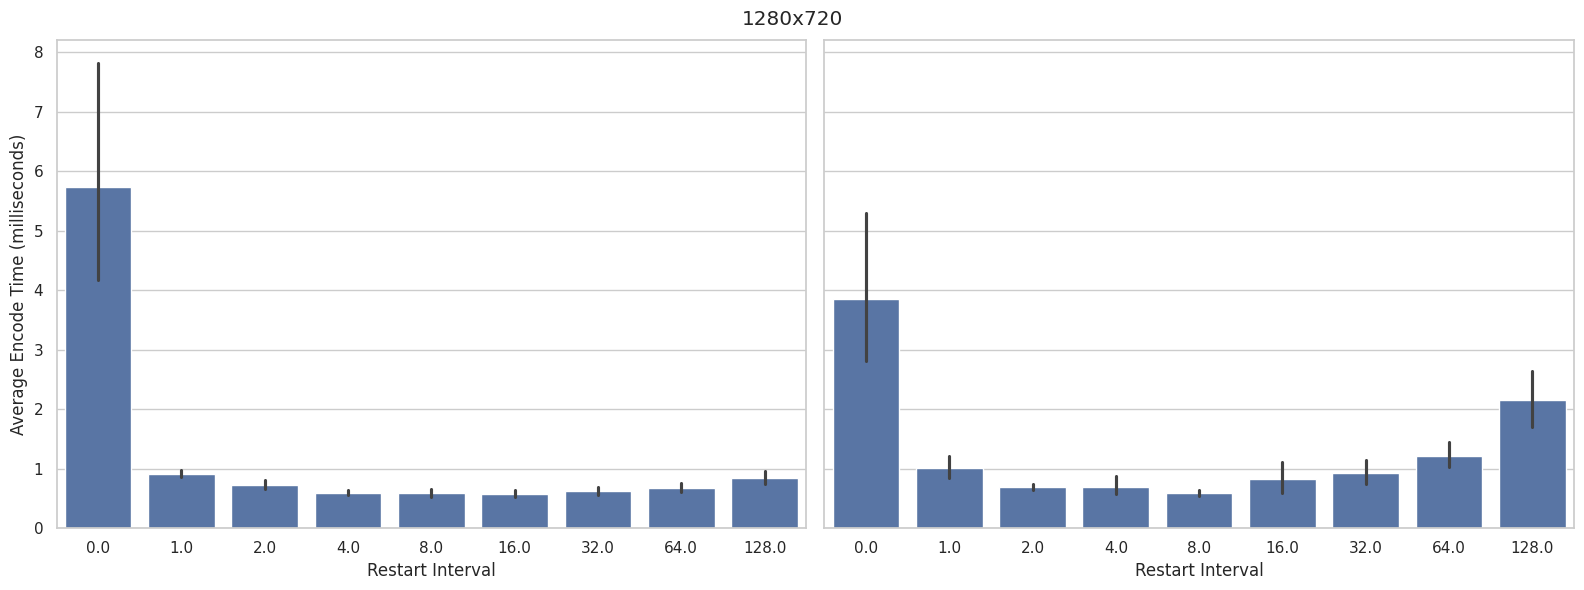

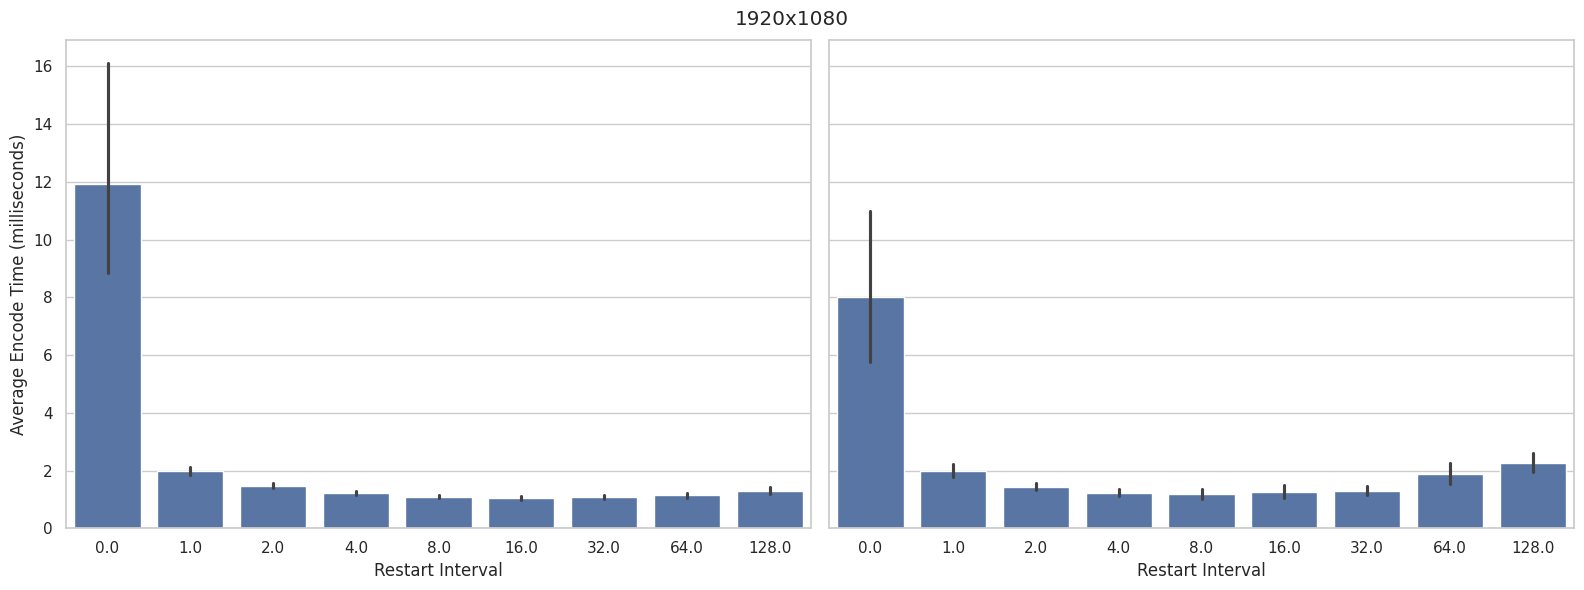

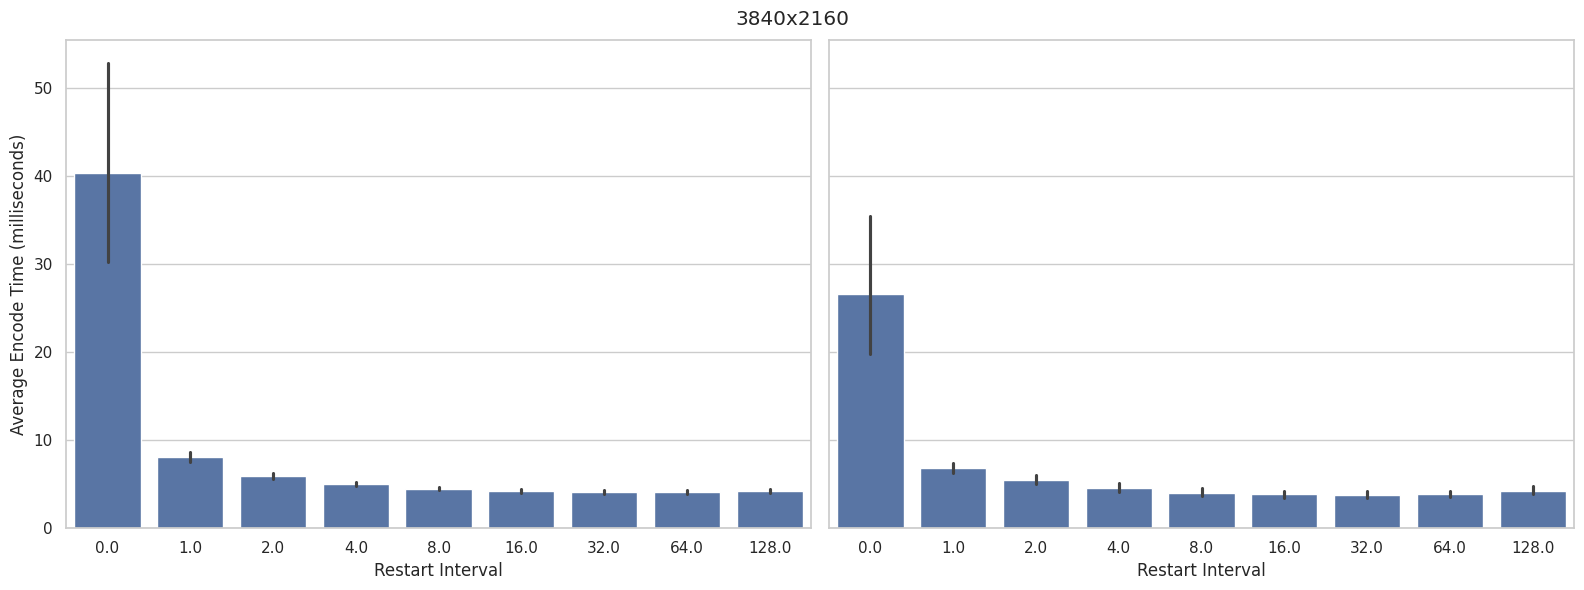

In [9]:
# 1280x720
fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
# Plot #1: Encoding time by Restart interval method
sns.barplot(
    data=df[df['Resolution'] == '1280x720'],
    x='Restart Interval',
    y=df['Avg Encode Time (s)'] * 1000,
    ax=ax[0]
)
ax[0].set_ylabel('Average Encode Time (milliseconds)')

# Plot #2: Decoding time by Subsampling method
sns.barplot(
    data=df[df['Resolution'] == '1280x720'],
    x='Restart Interval',
    y=df['Avg Decode Time (s)'] * 1000,
    ax=ax[1]
)
ax[1].set_ylabel('Average Encode Time (milliseconds)')
plt.tight_layout(rect=[0.0, 0.0, 1.0, 0.96])
fig.suptitle("1280x720")
plt.show()

# 1920x1080
fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
# Plot #1: Encoding time by Restart interval method
sns.barplot(
    data=df[df['Resolution'] == '1920x1080'],
    x='Restart Interval',
    y=df['Avg Encode Time (s)'] * 1000,
    ax=ax[0]
)
ax[0].set_ylabel('Average Encode Time (milliseconds)')

# Plot #2: Decoding time by Subsampling method
sns.barplot(
    data=df[df['Resolution'] == '1920x1080'],
    x='Restart Interval',
    y=df['Avg Decode Time (s)'] * 1000,
    ax=ax[1]
)
ax[1].set_ylabel('Average Encode Time (milliseconds)')
plt.tight_layout(rect=[0.0, 0.0, 1.0, 0.96])
fig.suptitle("1920x1080")
plt.show()

# 3840x2160
fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
# Plot #1: Encoding time by Restart interval method
sns.barplot(
    data=df[df['Resolution'] == '3840x2160'],
    x='Restart Interval',
    y=df['Avg Encode Time (s)'] * 1000,
    ax=ax[0]
)
ax[0].set_ylabel('Average Encode Time (milliseconds)')

# Plot #2: Decoding time by Subsampling method
sns.barplot(
    data=df[df['Resolution'] == '3840x2160'],
    x='Restart Interval',
    y=df['Avg Decode Time (s)'] * 1000,
    ax=ax[1]
)
ax[1].set_ylabel('Average Encode Time (milliseconds)')
plt.tight_layout(rect=[0.0, 0.0, 1.0, 0.96])
fig.suptitle("3840x2160")
plt.show()

In [10]:
df = df[df['Restart Interval'] > 0]

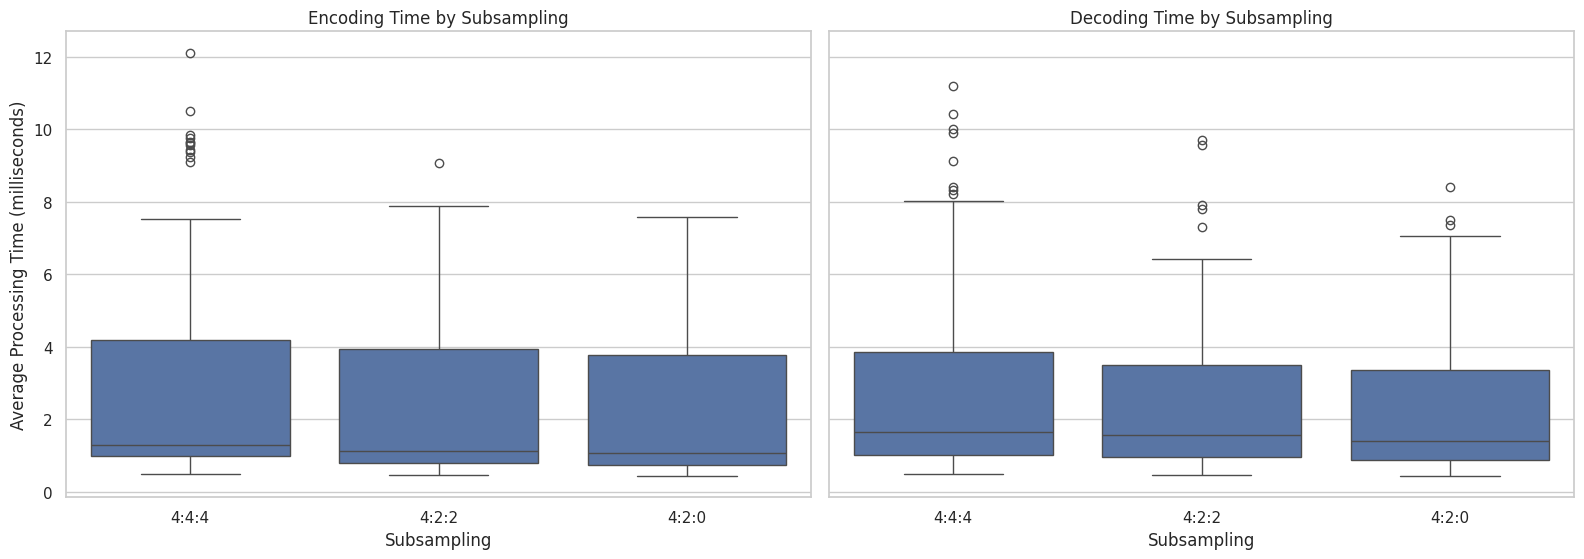

In [11]:
## Encoding Parameters vs. Performance
fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
# Plot #1: Encoding time by Subsampling method
sns.boxplot(
    data=df,
    x='Subsampling',
    y=df['Avg Encode Time (s)'] * 1000,
    order=SUBSAMPLINGS,
    ax=ax[0]
)
ax[0].set_title('Encoding Time by Subsampling')
ax[0].set_ylabel('Average Processing Time (milliseconds)')

# Plot #2: Decoding time by Subsampling method
sns.boxplot(
    data=df,
    x='Subsampling',
    y=df['Avg Decode Time (s)'] * 1000,
    order=SUBSAMPLINGS,
    ax=ax[1]
)
ax[1].set_title('Decoding Time by Subsampling')
plt.tight_layout(rect=[0.0, 0.0, 1.0, 0.96])
plt.show()

In [12]:
df = df[df['Subsampling'] == "4:2:0"]

In [13]:
df_hd = df[(df['Restart Interval'] == 8) & (df['Resolution'] == "1280x720")]
df_fullhd = df[(df['Restart Interval'] == 16) & (df['Resolution'] == "1920x1080")]
df_ultrahd = df[(df['Restart Interval'] == 32) & (df['Resolution'] == "3840x2160")]
df = df[((df['Restart Interval'] == 8) & (df['Resolution'] == "1280x720")) | ((df['Restart Interval'] == 16) & (df['Resolution'] == "1920x1080")) | ((df['Restart Interval'] == 32) & (df['Resolution'] == "3840x2160"))]

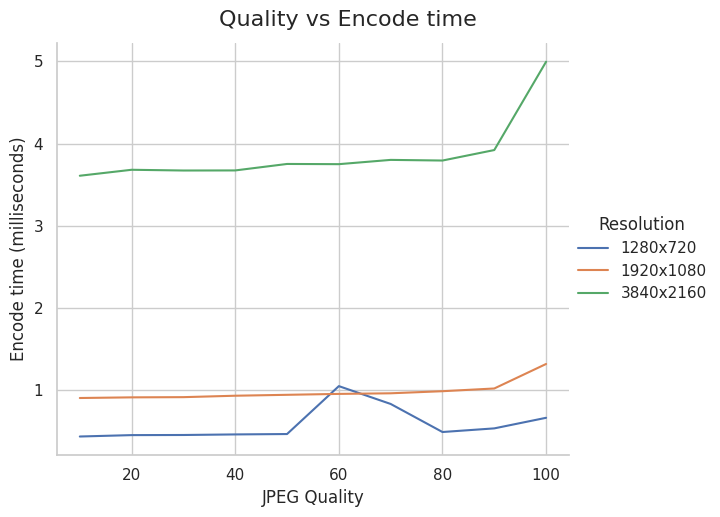

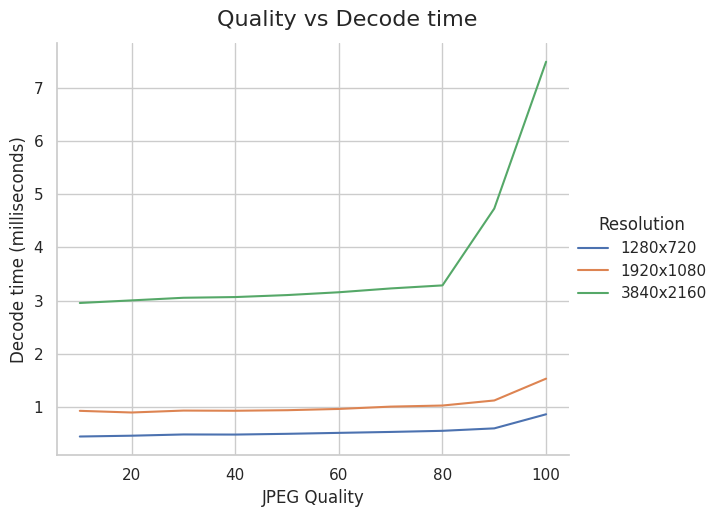

In [14]:
g = sns.relplot(
    data=df,
    x='Quality',
    y=df['Avg Encode Time (s)'] * 1000,
    hue='Resolution',
    kind='line',
    height=5,
    aspect=1.2,
    facet_kws={'sharey': False}
)
g.figure.suptitle('Quality vs Encode time', y=1.03, fontsize=16)
g.set_axis_labels('JPEG Quality', 'Encode time (milliseconds)')
plt.show()

g = sns.relplot(
    data=df,
    x='Quality',
    y=df['Avg Decode Time (s)'] * 1000,
    hue='Resolution',
    kind='line',
    height=5,
    aspect=1.2,
    facet_kws={'sharey': False}
)
g.figure.suptitle('Quality vs Decode time', y=1.03, fontsize=16)
g.set_axis_labels('JPEG Quality', 'Decode time (milliseconds)')
plt.show()

In [15]:
df = df[df['Avg Encode Time (s)'] * 1000 + df['Avg Decode Time (s)'] * 1000 <= 2 * 2]
#df = df[df['Avg Encode Time (s)'] * 1000 <= 2]
#df = df[df['Avg Decode Time (s)'] * 1000 <= 2]
df.sort_values(by='SSIM', ascending=False).head(5)

,Resolution,Quality,Format,Restart Interval,Subsampling,Iterations,Avg Encode Time (s),Encoder Setup Time (s),Encoder Cleanup Time (s),Avg Decode Time (s),Decoder Setup Time (s),Decoder Cleanup Time (s),Compressed Size (KB),PSNR,SSIM,Encode CMD,Decode CMD
535,1280x720,100,interleaved,8,4:2:0,10,0.000662,0.108257,0.000593,0.000856,0.117340,0.000906,747.017,38.277729,0.976556,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
1076,1920x1080,100,interleaved,16,4:2:0,10,0.001317,0.112760,0.001751,0.001528,0.114864,0.001143,1549.335,38.980778,0.974701,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
481,1280x720,90,interleaved,8,4:2:0,10,0.000533,0.113414,0.001091,0.000591,0.125385,0.000848,243.609,36.234245,0.956919,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
1022,1920x1080,90,interleaved,16,4:2:0,10,0.001019,0.112822,0.001687,0.001116,0.111387,0.001128,473.143,36.998627,0.955718,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
968,1920x1080,80,interleaved,16,4:2:0,10,0.000986,0.114070,0.001671,0.001021,0.111473,0.001126,319.979,36.085644,0.946172,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...


In [16]:
df = df[df['Avg Encode Time (s)'] * 1000 + df['Avg Decode Time (s)'] * 1000 <= 1.5 * 2]
#df = df[df['Avg Encode Time (s)'] * 1000 <= 1.5]
#df = df[df['Avg Decode Time (s)'] * 1000 <= 1.5]
df.sort_values(by='SSIM', ascending=False).head(5)

,Resolution,Quality,Format,Restart Interval,Subsampling,Iterations,Avg Encode Time (s),Encoder Setup Time (s),Encoder Cleanup Time (s),Avg Decode Time (s),Decoder Setup Time (s),Decoder Cleanup Time (s),Compressed Size (KB),PSNR,SSIM,Encode CMD,Decode CMD
535,1280x720,100,interleaved,8,4:2:0,10,0.000662,0.108257,0.000593,0.000856,0.117340,0.000906,747.017,38.277729,0.976556,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
1076,1920x1080,100,interleaved,16,4:2:0,10,0.001317,0.112760,0.001751,0.001528,0.114864,0.001143,1549.335,38.980778,0.974701,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
481,1280x720,90,interleaved,8,4:2:0,10,0.000533,0.113414,0.001091,0.000591,0.125385,0.000848,243.609,36.234245,0.956919,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
1022,1920x1080,90,interleaved,16,4:2:0,10,0.001019,0.112822,0.001687,0.001116,0.111387,0.001128,473.143,36.998627,0.955718,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
968,1920x1080,80,interleaved,16,4:2:0,10,0.000986,0.114070,0.001671,0.001021,0.111473,0.001126,319.979,36.085644,0.946172,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...


In [17]:
df = df[df['Avg Encode Time (s)'] * 1000 + df['Avg Decode Time (s)'] * 1000 <= 1 * 2]
#df = df[df['Avg Encode Time (s)'] * 1000 <= 1]
#df = df[df['Avg Decode Time (s)'] * 1000 <= 1]
df[df['Resolution'] == '1280x720'].sort_values(by='SSIM', ascending=False).head(5)

,Resolution,Quality,Format,Restart Interval,Subsampling,Iterations,Avg Encode Time (s),Encoder Setup Time (s),Encoder Cleanup Time (s),Avg Decode Time (s),Decoder Setup Time (s),Decoder Cleanup Time (s),Compressed Size (KB),PSNR,SSIM,Encode CMD,Decode CMD
535,1280x720,100,interleaved,8,4:2:0,10,0.000662,0.108257,0.000593,0.000856,0.117340,0.000906,747.017,38.277729,0.976556,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
481,1280x720,90,interleaved,8,4:2:0,10,0.000533,0.113414,0.001091,0.000591,0.125385,0.000848,243.609,36.234245,0.956919,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
427,1280x720,80,interleaved,8,4:2:0,10,0.000489,0.109843,0.000558,0.000544,0.113963,0.000901,167.328,35.098106,0.945294,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
373,1280x720,70,interleaved,8,4:2:0,10,0.000831,0.120955,0.000608,0.000523,0.111961,0.000875,135.047,34.232830,0.935344,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
319,1280x720,60,interleaved,8,4:2:0,10,0.001048,0.114786,0.000667,0.000506,0.114269,0.000886,114.878,33.515984,0.925720,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...


In [18]:
df[df['Resolution'] == '1920x1080'].sort_values(by='SSIM', ascending=False).head(5)

,Resolution,Quality,Format,Restart Interval,Subsampling,Iterations,Avg Encode Time (s),Encoder Setup Time (s),Encoder Cleanup Time (s),Avg Decode Time (s),Decoder Setup Time (s),Decoder Cleanup Time (s),Compressed Size (KB),PSNR,SSIM,Encode CMD,Decode CMD
914,1920x1080,70,interleaved,16,4:2:0,10,0.000960,0.110866,0.001672,0.001000,0.110955,0.001131,256.635,35.323792,0.937507,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
860,1920x1080,60,interleaved,16,4:2:0,10,0.000953,0.113915,0.001635,0.000957,0.116161,0.001134,217.126,34.704063,0.929653,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
806,1920x1080,50,interleaved,16,4:2:0,10,0.000942,0.114724,0.000656,0.000933,0.111292,0.001187,191.657,34.177498,0.922121,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
752,1920x1080,40,interleaved,16,4:2:0,10,0.000931,0.111389,0.001702,0.000923,0.112510,0.001168,168.025,33.550243,0.912599,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
698,1920x1080,30,interleaved,16,4:2:0,10,0.000913,0.108886,0.000666,0.000926,0.109756,0.001142,143.710,32.530022,0.897892,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...


In [19]:
df = df[df['Avg Encode Time (s)'] * 1000 + df['Avg Decode Time (s)'] * 1000 <= 0.5 * 2]
#df = df[df['Avg Encode Time (s)'] * 1000 <= 0.5]
#df = df[df['Avg Decode Time (s)'] * 1000 <= 0.5]
df[df['Resolution'] == '1280x720'].sort_values(by='SSIM', ascending=False).head(5)

,Resolution,Quality,Format,Restart Interval,Subsampling,Iterations,Avg Encode Time (s),Encoder Setup Time (s),Encoder Cleanup Time (s),Avg Decode Time (s),Decoder Setup Time (s),Decoder Cleanup Time (s),Compressed Size (KB),PSNR,SSIM,Encode CMD,Decode CMD
265,1280x720,50,interleaved,8,4:2:0,10,0.000464,0.110722,0.001111,0.000488,0.116300,0.000862,101.659,32.947857,0.917258,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
211,1280x720,40,interleaved,8,4:2:0,10,0.000460,0.109035,0.001101,0.000474,0.111302,0.000854,89.438,32.361523,0.907010,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
157,1280x720,30,interleaved,8,4:2:0,10,0.000453,0.111760,0.001106,0.000476,0.114323,0.000914,76.816,31.537010,0.892111,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
103,1280x720,20,interleaved,8,4:2:0,10,0.000451,0.111641,0.001034,0.000452,0.109791,0.000870,61.673,30.205994,0.863375,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
49,1280x720,10,interleaved,8,4:2:0,10,0.000434,0.117526,0.001126,0.000437,0.110320,0.000855,43.094,27.668692,0.795669,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...


In [20]:
df[df['Resolution'] == '1920x1080'].sort_values(by='SSIM', ascending=False).head(5)

,Resolution,Quality,Format,Restart Interval,Subsampling,Iterations,Avg Encode Time (s),Encoder Setup Time (s),Encoder Cleanup Time (s),Avg Decode Time (s),Decoder Setup Time (s),Decoder Cleanup Time (s),Compressed Size (KB),PSNR,SSIM,Encode CMD,Decode CMD


In [21]:
df = df[df['Avg Encode Time (s)'] * 1000 + df['Avg Decode Time (s)'] * 1000 <= 0.45 * 2]
#df = df[df['Avg Encode Time (s)'] * 1000 <= 0.5]
#df = df[df['Avg Decode Time (s)'] * 1000 <= 0.5]
df.sort_values(by='SSIM', ascending=False).head(5)

,Resolution,Quality,Format,Restart Interval,Subsampling,Iterations,Avg Encode Time (s),Encoder Setup Time (s),Encoder Cleanup Time (s),Avg Decode Time (s),Decoder Setup Time (s),Decoder Cleanup Time (s),Compressed Size (KB),PSNR,SSIM,Encode CMD,Decode CMD
49,1280x720,10,interleaved,8,4:2:0,10,0.000434,0.117526,0.001126,0.000437,0.11032,0.000855,43.094,27.668692,0.795669,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
